### **Описание проекта**

**Описание проекта**

Я работаю в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения.

Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента будем работать с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

### **Подготовка к работе**

Подключим гугл-диск

Я выполняю проект в гугл-колаб, поэтому сперва установим соединение с гугл-диском. Код закроем в try-except для исключения конфликта при ревью.

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  print('Подключение к google-drive не выполнено. Вы просматриваете проект в другой среде. Код запущен далее.')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Загрузка библиотек для работы

In [ ]:
# colab часто выдаёт предупреждения - скроем их
import warnings
warnings.filterwarnings("ignore")
# загрузим библиотеки: сперва основную для работы
import pandas as pd
# для "красоты" (графики и оформление)
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
# для математических и статистических операций
import numpy as np
import math as mth
import scipy.stats
from scipy import stats as st
# также загрузим os для создания двойного пути к базе данных
import os

Заранее зададим общий стиль своим графикам и диаграммам:

In [ ]:
large = 16; med = 12; small = 10
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (12, 8),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
# на мой взгляд лучше всего подходит палитра deep
# она не пёстрая, относительно контрастная
# однако в реальном заказе я предпочёл бы принятые у заказчика цвета для подобной работы
sns.set_palette('deep') 
sns.set_style("whitegrid")

### **Ознакомление с данными**

*Откройте файл с данными и изучите общую информацию*

Загрузка базы данных. Используем двойной путь к базе данных (с моего гугл-диска и с хранилища практикума), чтобы исключить ошибку при ревью.

In [ ]:
pth1 = '/content/drive/MyDrive/Colab Notebooks/Яндекс_практикум/Сборный_проект_2/logs_exp.csv'
pth2 = '/datasets/logs_exp.csv'
if os.path.exists(pth1):
  df = pd.read_csv(pth1, delimiter='\t')
elif os.path.exists(pth2):
  df = pd.read_csv(pth2, delimiter='\t')
else:
  print('Проверьте правильность пути к датасету')

Ознакомимся с данными:

1.   посмотрим "шапку" таблицы и выпишем значения столбцов
2.   проверим общие данные методом info()
3.   проверим пропуски
4.   проверим дубликаты

In [ ]:
df.head(3)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248


Описание данных:
*   EventName — название события
*   DeviceIDHash — уникальный идентификатор пользователя
*   EventTimestamp — время события
*   ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [ ]:
df.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [ ]:
df.duplicated().sum()

413

ИТОГО:

*   колонки имеют стилистические ошибки - исправим их для удобства работы
*   колонка времени в неподходящем формате
*   имеются полные дубликаты



### **Предобработка**

*Подготовьте данные:*

*   *Замените названия столбцов на удобные для вас*
*   *Проверьте пропуски и типы данных. Откорректируйте, если нужно*
*   *Добавьте столбец даты и времени, а также отдельный столбец дат*

**Переименуем столбцы в стилистически правильные**

In [ ]:
df.columns = ['event_name', 'user_id', 'event_timestamp', 'exp_id']
df.head(3)

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248


**Удалим дубликаты**

In [ ]:
df = df.drop_duplicates().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       243713 non-null  object
 1   user_id          243713 non-null  int64 
 2   event_timestamp  243713 non-null  int64 
 3   exp_id           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


Учитывая наличие столбца уникальных идентификаторов, проведём также поиск и удаление дубликатов без учёта данного столбца:

In [ ]:
df = df.drop_duplicates(subset=['event_name', 'event_timestamp', 'exp_id'], keep=False)
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230178 entries, 0 to 230177
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       230178 non-null  object
 1   user_id          230178 non-null  int64 
 2   event_timestamp  230178 non-null  int64 
 3   exp_id           230178 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.0+ MB


Очистим датасет от пользователей, которые попали в две и более экспериментальных групп. 

У нас три группы: условно говоря, это 1, 2 и 3. Они могут дать три парных варианта: 1-2, 1-3 или 2-3. В тройной вариант 1-2-3 войдёт любой парный вариант. Поэтому пробежим циклами по парным вариантам уникальных id, внесём в пустой список тех, кто замечен хотя бы в двух группах одновременно, и используем список для логической фильтрации

In [ ]:
# составим срез по экспериментам
gr_c1 = df.query('exp_id == 246')
gr_c2 = df.query('exp_id == 247')
gr_ex = df.query('exp_id == 248')
# соберём уникальные id в экспериментах
unique_c1 = gr_c1['user_id'].unique()
unique_c2 = gr_c2['user_id'].unique()
unique_ex = gr_ex['user_id'].unique()
# создадим пустой список
multi_users = []
# цикл для пар 1-2 и 1-3
for i in unique_c1:
    if i in unique_c2:
        multi_users.append(i)
    if i in unique_ex:
        multi_users.append(i)
# цикл для пары 2-3
for i in unique_c2:
    if i in unique_ex:
        multi_users.append(i)

# цикл для логической фильтрации
for i in df['user_id']:
    if i in multi_users:
        df = df.loc[df['user_id'] != i]

df = df.reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230178 entries, 0 to 230177
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       230178 non-null  object
 1   user_id          230178 non-null  int64 
 2   event_timestamp  230178 non-null  int64 
 3   exp_id           230178 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.0+ MB


Полные дубликаты удалены, дубликаты без учёта идентификатора пользователя удалены, после чего пользователей, попавших в две и более групп не нашлось.

---





**Добавим столбец даты и времени, а также отдельный столбец дат**

In [ ]:
df['date_time'] = pd.to_datetime(df['event_timestamp'], unit='s')
df['date'] = df['date_time'].astype('datetime64[D]')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230178 entries, 0 to 230177
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       230178 non-null  object        
 1   user_id          230178 non-null  int64         
 2   event_timestamp  230178 non-null  int64         
 3   exp_id           230178 non-null  int64         
 4   date_time        230178 non-null  datetime64[ns]
 5   date             230178 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 10.5+ MB


In [ ]:
df.head(3)

,event_name,user_id,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25


### **Изучение данных**

**1) сколько всего событий в логе?**

In [ ]:
print('Всего событий %d, типов событий %d.' % (df.shape[0], df['event_name'].nunique()))

Всего событий 230178, типов событий 5.


**2) сколько всего пользователей в логе?**

In [ ]:
print('Всего пользователей в логе %d.' % (df['user_id'].nunique()))

Всего пользователей в логе 7539.


**3) сколько в среднем событий приходится на пользователя?**

In [ ]:
print('В среднем событий на пользователя %d.' % (df.shape[0] / df['user_id'].nunique()))

В среднем событий на пользователя 30.


**4) данными за какой период вы располагаете?**

Найдите максимальную и минимальную дату.

Постройте гистограмму по дате и времени.

Можно ли быть уверенным, что у вас одинаково полные данные за весь период?

Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные».

Определите, с какого момента данные полные и отбросьте более старые.

Данными за какой период времени вы располагаете на самом деле?

In [ ]:
np.ptp(df['event_timestamp'].to_numpy())

1182701

In [ ]:
delta_time = pd.to_timedelta(1182701, unit='s')

In [ ]:
firts_date = df['date_time'].min()
last_date = df['date_time'].max()

In [ ]:
print('Данные от %s до %s, разница в %s.' % (firts_date, last_date, delta_time))

Данные от 2019-07-25 04:43:36 до 2019-08-07 21:15:17, разница в 13 days 16:31:41.


In [ ]:
temp = df.groupby(by='date').agg({'event_name': 'count'}).reset_index()
temp['percent'] = temp['event_name'] / temp['event_name'].sum() * 100
# отдельно посчитаем пошаговую суммацию процента данных по времени
temp['cum_sum'] = temp['percent'].cumsum()
temp

,date,event_name,percent,cum_sum
0,2019-07-25,9,0.003910,0.003910
1,2019-07-26,31,0.013468,0.017378
2,2019-07-27,55,0.023895,0.041272
3,2019-07-28,105,0.045617,0.086889
4,2019-07-29,184,0.079938,0.166827
5,2019-07-30,412,0.178992,0.345819
6,2019-07-31,2020,0.877582,1.223401
7,2019-08-01,33972,14.759013,15.982414
8,2019-08-02,33636,14.613039,30.595452
9,2019-08-03,31576,13.718079,44.313531


Данные полные.

Построим гистограмму:

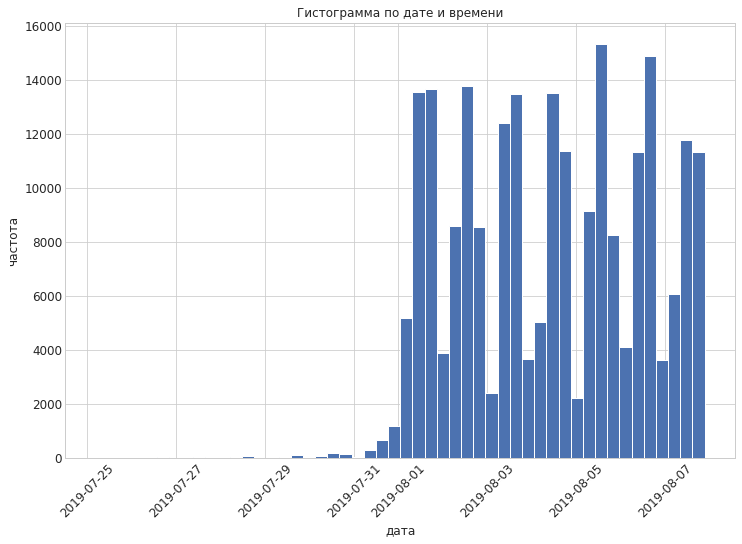

In [ ]:
ax = df['date_time'].hist(bins=50)
plt.title('Гистограмма по дате и времени')
plt.ylabel("частота")
plt.xlabel("дата")
plt.xticks(rotation=45)
plt.show()

Значимые данные мы имеем с 2019-07-31, откуда прослеживается их заметный рост. Выведем очищенные по дате данные в отдельный датафрейм.

In [ ]:
df_clean = df.loc[df['date'] > '2019-07-31']

**5) Много ли событий и пользователей вы потеряли, отбросив старые данные?**

In [ ]:
print('СТАРЫЕ ДАННЫЕ: Всего событий %d, типов событий %d.' % (df.shape[0], df['event_name'].nunique()))
print('ПОСЛЕ ОЧИСТКИ: Всего событий %d, типов событий %d.' % (df_clean.shape[0], df_clean['event_name'].nunique()))

СТАРЫЕ ДАННЫЕ: Всего событий 230178, типов событий 5.
ПОСЛЕ ОЧИСТКИ: Всего событий 227362, типов событий 5.


In [ ]:
print('СТАРЫЕ ДАННЫЕ: Всего пользователей в логе %d.' % (df['user_id'].nunique()))
print('ПОСЛЕ ОЧИСТКИ: Всего пользователей в логе %d.' % (df_clean['user_id'].nunique()))

СТАРЫЕ ДАННЫЕ: Всего пользователей в логе 7539.
ПОСЛЕ ОЧИСТКИ: Всего пользователей в логе 7521.


In [ ]:
print('СТАРЫЕ ДАННЫЕ: В среднем событий на пользователя %d.' % (df.shape[0] / df['user_id'].nunique()))
print('ПОСЛЕ ОЧИСТКИ: В среднем событий на пользователя %d.' % (df_clean.shape[0] / df_clean['user_id'].nunique()))

СТАРЫЕ ДАННЫЕ: В среднем событий на пользователя 30.
ПОСЛЕ ОЧИСТКИ: В среднем событий на пользователя 30.


ИТОГО:

*   Очищено несколько тысяч событий
*   Количество анализируемых пользователей при этом уменьшилось незначительно
*   Количество событий на пользователя не изменилось



In [ ]:
per_shape = 100 - (df_clean.shape[0] / df.shape[0] * 100)
per_users = 100 - (df_clean['user_id'].nunique() / df['user_id'].nunique() * 100)
print(f'При очистке из рассчётов выведено событий: {per_shape}%')
print(f'При очистке из рассчётов выведено пользователей: {per_users}%')

При очистке из рассчётов выведено событий: 1.223401020080118%
При очистке из рассчётов выведено пользователей: 0.23875845602864842%


**6) Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп**

In [ ]:
df_clean.groupby('exp_id').agg({'user_id': 'nunique'})

,user_id
exp_id,
246,2480
247,2508
248,2533


Пользователи всех трёх групп сохранены, количество их в группах слабо различается.

### **Изучите воронку событий**

**1) посмотрите, какие события есть в логах, как часто они встречаются**

Отсортируйте события по частоте

In [ ]:
# составим сводную таблицу по очищенным данным, посчитав события по идентификаторам пользователей
df_clean.pivot_table(values='user_id', index='event_name', aggfunc='count').sort_values(by='user_id', ascending=False)

,user_id
event_name,
MainScreenAppear,107716
OffersScreenAppear,44733
CartScreenAppear,40896
PaymentScreenSuccessful,33012
Tutorial,1005


**2) посчитайте, сколько пользователей совершали каждое из этих событий**

Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие

In [ ]:
# запишем данные в датасет funnel (анг. "воронка")
# сгруппируем данные в сиреес, отсортируем, переведём в датафрейм, сменим имя колонки на более подходящее
# добавим колонку процента пользователей, совершивших событие
funnel = df_clean.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()\
        .rename(columns={'user_id': 'total_users'})
funnel['percent'] = funnel['total_users'] / df_clean['user_id'].nunique() * 100
funnel['percent'] = funnel['percent'].round(2)
funnel

,event_name,total_users,percent
0,MainScreenAppear,7389,98.24
1,OffersScreenAppear,4571,60.78
2,CartScreenAppear,3729,49.58
3,PaymentScreenSuccessful,3529,46.92
4,Tutorial,840,11.17


**3) предположите, в каком порядке происходят события**

Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Туториал, как в большинстве приложений, пользователь может пропустить, иначе на его долю приходился бы более существенный процент. Тогда цепочка событий выглядит следующим образом:

1) главный экран 

2) предложение

3) корзина

4) экран платежа

Отфильтруем датасет воронки от туториала:

In [ ]:
funnel = funnel[:4]
funnel

,event_name,total_users,percent
0,MainScreenAppear,7389,98.24
1,OffersScreenAppear,4571,60.78
2,CartScreenAppear,3729,49.58
3,PaymentScreenSuccessful,3529,46.92


**4) по воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)**

То есть для последовательности событий A -> B -> C, посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A.

In [ ]:
fig = go.Figure()
fig = go.Figure(go.Funnel(
    y = funnel['event_name'],
    x = funnel['total_users']))
fig.show()

**5) на каком шаге теряете больше всего пользователей?**

Больше всего пользователей теряется на этапе "главный экран"

**6) какая доля пользователей доходит от первого события до оплаты?**

47.8% пользователей начального этапа

### **Изучите результаты эксперимента**

**1) Сколько пользователей в каждой экспериментальной группе?**

In [ ]:
users = df_clean.groupby('exp_id')['user_id'].nunique()
users

exp_id
246    2480
247    2508
248    2533
Name: user_id, dtype: int64

Группы незначительно различаются по численности: 246-2480, 247-2508, 248-2533.

**2) есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов**

Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

*Критерии успешного A/A-теста:*


*   Количество пользователей, попавших в различные группы, отличается
не более, чем на 0.5%
*   Данные во всех группах отправляются в системы аналитики
одинаково
*   Различие ключевых метрик по группам не более 1% и не имеет
статистической значимости
*   Каждый посетитель, попавший в одну из групп теста, остаётся в этой
группе до конца теста. Если пользователь видит разные вариации
A/B теста в течение одного исследования, неизвестно, какая из них
повлияла на него. Значит, и результаты теста нельзя
интерпретировать однозначно.

In [ ]:
# выведем пользователей групп в отдельные сеты, сбросив при этом все события туториала
exp_246 = df_clean[(df_clean['exp_id'] == 246) & (df_clean['event_name'] != 'Tutorial')]
exp_247 = df_clean[(df_clean['exp_id'] == 247) & (df_clean['event_name'] != 'Tutorial')]
exp_248 = df_clean[(df_clean['exp_id'] == 248) & (df_clean['event_name'] != 'Tutorial')]

*Количество пользователей, попавших в различные группы, отличается не более, чем на 0.5%.*

In [ ]:
AA_perc = 100 - (exp_246['user_id'].nunique() / exp_247['user_id'].nunique() * 100)
print('Разница между групп АА-теста составляет {} %'.format(AA_perc))

Разница между групп АА-теста составляет 1.1168727562824046 %


*Данные во всех группах отправляются в системы аналитики одинаково. Различие ключевых метрик по группам не более 1% и не имеет статистической значимости.*

Построим для каждой группы воронку событий и сопоставим их вместе

In [ ]:
funnel_246 = exp_246.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()\
        .rename(columns={'user_id': 'total_users'})
funnel_247 = exp_247.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()\
        .rename(columns={'user_id': 'total_users'})
funnel_248 = exp_248.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()\
        .rename(columns={'user_id': 'total_users'})
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'exp 246',
    y = funnel_246['event_name'],
    x = funnel_246['total_users'],
    ))

fig.add_trace(go.Funnel(
    name = 'exp 247',
    y = funnel_247['event_name'],
    x = funnel_247['total_users'],
    ))

fig.add_trace(go.Funnel(
    name = 'exp 248',
    y = funnel_248['event_name'],
    x = funnel_248['total_users'],
    ))

fig.show()

*Каждый посетитель, попавший в одну из групп теста, остаётся в этой группе до конца теста*

Этот вопрос мы решили на предобработке данных, проверив группы на совпадения по пользователям.

ИТОГО:

Критерии соблюдены не полноценно: есть разница в группах по проценту. Но прочие критерии позволяют использовать группы далее.

**3) Выберите самое популярное событие**

Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. 

Посчитайте долю пользователей, совершивших это событие. 

Проверьте, будет ли отличие между группами статистически достоверным. 

Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). 

Можно ли сказать, что разбиение на группы работает корректно?

Самое популярное событие: главный экран. 

Выполним рассчёты в сводной таблице

In [ ]:
all_funnels = df_clean.pivot_table(index='event_name', columns='exp_id',values='user_id',aggfunc='nunique')\
                       .sort_values(246,ascending=False)
all_funnels['246+247'] = all_funnels[246] + all_funnels[247]
all_funnels.drop(['Tutorial'], inplace=True)
all_funnels

exp_id,246,247,248,246+247
event_name,,,,
MainScreenAppear,2439,2466,2484,4905
OffersScreenAppear,1536,1514,1521,3050
CartScreenAppear,1265,1236,1228,2501
PaymentScreenSuccessful,1196,1154,1179,2350


In [ ]:
users = users.to_frame().reset_index()
users.loc[3] = ['246+247', 4997]

In [ ]:
users = users.set_index(users.columns[0])
users

,user_id
exp_id,
246,2480
247,2508
248,2533
246+247,4997


*Проверьте, будет ли отличие между группами статистически достоверным. 
Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию).*

Для проверки статистической значимости сформируем гипотезы:

1) нулевая гипотеза: статистической разницы нет

2) альтернативная гипотеза: группы статически различаются

In [ ]:
# построим функцию по проверке гипотезы на основе Z-критериев
def z_test(exp1, exp2, event, alpha): 
    p1_ev = all_funnels.loc[event, exp1]
    p2_ev = all_funnels.loc[event, exp2] 
    p1_us = users.loc[exp1, 'user_id'] 
    p2_us = users.loc[exp2, 'user_id'] 
    p1 = p1_ev / p1_us 
    p2 = p2_ev / p2_us 
    difference = p1 - p2
    p_combined = (p1_ev + p2_ev) / (p1_us + p2_us) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_us + 1 / p2_us))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Проверка для  {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(exp1, exp2, event, p_value=p_value))
    if (p_value < alpha):
        print("Выявлена статистически значимая разница")
    else:
        print("Статистически значимая разница не обнаружена")

In [ ]:
for event in all_funnels.index:
    z_test(246, 247, event, 0.05)
    print()

Проверка для  246 и 247, событие: MainScreenAppear, p-значение: 0.95
Статистически значимая разница не обнаружена

Проверка для  246 и 247, событие: OffersScreenAppear, p-значение: 0.26
Статистически значимая разница не обнаружена

Проверка для  246 и 247, событие: CartScreenAppear, p-значение: 0.22
Статистически значимая разница не обнаружена

Проверка для  246 и 247, событие: PaymentScreenSuccessful, p-значение: 0.12
Статистически значимая разница не обнаружена



**4) Аналогично поступите с группой с изменённым шрифтом**

Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

Для проверки статистической значимости сформируем гипотезы:

1) нулевая гипотеза: статистической разницы нет

2) альтернативная гипотеза: группы статически различаются

Вновь применим функцию

In [ ]:
for event in all_funnels.index:
    z_test(246, 248, event, 0.05)
    print()

Проверка для  246 и 248, событие: MainScreenAppear, p-значение: 0.45
Статистически значимая разница не обнаружена

Проверка для  246 и 248, событие: OffersScreenAppear, p-значение: 0.17
Статистически значимая разница не обнаружена

Проверка для  246 и 248, событие: CartScreenAppear, p-значение: 0.07
Статистически значимая разница не обнаружена

Проверка для  246 и 248, событие: PaymentScreenSuccessful, p-значение: 0.23
Статистически значимая разница не обнаружена



In [ ]:
for event in all_funnels.index:
    z_test(247, 248, event, 0.05)
    print()

Проверка для  247 и 248, событие: MainScreenAppear, p-значение: 0.49
Статистически значимая разница не обнаружена

Проверка для  247 и 248, событие: OffersScreenAppear, p-значение: 0.82
Статистически значимая разница не обнаружена

Проверка для  247 и 248, событие: CartScreenAppear, p-значение: 0.57
Статистически значимая разница не обнаружена

Проверка для  247 и 248, событие: PaymentScreenSuccessful, p-значение: 0.70
Статистически значимая разница не обнаружена



In [ ]:
for event in all_funnels.index:
    z_test('246+247', 248, event, 0.05)
    print()

Проверка для  246+247 и 248, событие: MainScreenAppear, p-значение: 0.78
Статистически значимая разница не обнаружена

Проверка для  246+247 и 248, событие: OffersScreenAppear, p-значение: 0.41
Статистически значимая разница не обнаружена

Проверка для  246+247 и 248, событие: CartScreenAppear, p-значение: 0.20
Статистически значимая разница не обнаружена

Проверка для  246+247 и 248, событие: PaymentScreenSuccessful, p-значение: 0.69
Статистически значимая разница не обнаружена



Вывод о различии долей сделать нельзя

**5) Какой уровень значимости выбрали при проверке статистических гипотез выше?**

Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы

Критерий в 5%.

4 AA теста и 12 (4 А1-В, 4 А2-В, 4 А(1+2)-В) AB тестов.

**ОБЩИЙ ВЫВОД**

Статистический анализ дал схожий результат с наглядным отображением путём построения воронки: значимых различий между группами не обнаружено, изменение шрифта дизайна существенных изменений не приносит. 